<h1 align=center> Global Wheat Detection with Keras RetinaNet </h1>

### This Notebook is for Training Purpose of Keras RetinaNet.
### RetinaNet is very slow as compared to F-RCNN so I've kept epochs and steps per epoch small for fast commiting purpose.
### I will make another notebook for inference Shortly.

### Credits for the EDA goes to [THIS Notebook](https://www.kaggle.com/devvindan/wheat-detection-eda)

<h3 align=center style=color:red>Upvote If you find this kernel interesting</h3>

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image, ImageDraw
from ast import literal_eval
import matplotlib.pyplot as plt
import urllib
from tqdm.notebook import tqdm

# Installing Keras-RetinaNet 

In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 5736 (delta 12), reused 16 (delta 5), pack-reused 5705
Receiving objects: 100% (5736/5736), 13.37 MiB | 32.30 MiB/s, done.
Resolving deltas: 100% (3843/3843), done.


In [3]:
%cd keras-retinanet/

!pip install .

/kaggle/working/keras-retinanet
Processing /kaggle/working/keras-retinanet
     |████████████████████████████████| 51 kB 63 kB/s  eta 0:00:011
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp37-cp37m-linux_x86_64.whl size=174672 sha256=812070d63da3a7df788add64cf35fc79536c5f6e35839940ce318f6e24d5b18c
  Stored in directory: /root/.cache/pip/wheels/7f/ae/f4/f38a5a29bced2617252cb8aa726369b755c87eeef59fbba1d1
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=9207415f6053c3e44fe3b66f6d00d6031ce81c9b5dbf71c94cc70da42a17aa2a
  Stored in directory: /root/.cache/pip/wheels/a6/20/57/d7b7be8556e2ebf36345b3df4068a9a13bb90e4a2cc85a6994
Successfully built keras-retinanet keras-resnet


In [4]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /kaggle/working/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/keras_retinanet
creating build/temp.linux-x86_64-3.7/keras_retinanet/utils
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/include/python3.7m -I/opt/conda/lib/python3.7/site-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.o
In file in

In [5]:
import tensorflow as tf
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

## Let's look at the data

In [6]:
root = "/kaggle/input/global-wheat-detection/"
train_img = root+"train"
test_img = root+"test"
train_csv = root+"train.csv"
sample_submission = root+"sample_submission.csv"

In [7]:
train = pd.read_csv(train_csv)
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

 Single Image has multiple bbox

In [8]:
print(f"Total Bboxes: {train.shape[0]}")

Total Bboxes: 147793


# EDA

Let's Check the Dimensions of images

In [9]:
train['width'].unique() == train['height'].unique() == [1024]

array([ True])

In [10]:
def get_bbox_area(bbox):
    bbox = literal_eval(bbox)
    return bbox[2] * bbox[3]

In [11]:
train['bbox_area'] = train['bbox'].apply(get_bbox_area)

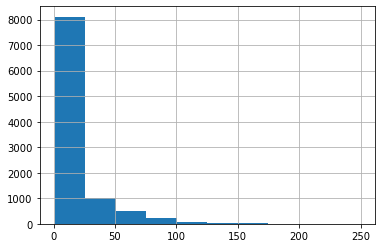

In [12]:
train['bbox_area'].value_counts().hist(bins=10)

In [13]:
unique_images = train['image_id'].unique()
len(unique_images)

3373

In [14]:
num_total = len(os.listdir(train_img))
num_annotated = len(unique_images)

print(f"There are {num_annotated} annotated images and {num_total - num_annotated} images without annotations.")

There are 3373 annotated images and 49 images without annotations.


### Sources of Data

In [15]:
sources = train['source'].unique()
print(f"There are {len(sources)} sources of data: {sources}")

There are 7 sources of data: ['usask_1' 'arvalis_1' 'inrae_1' 'ethz_1' 'arvalis_3' 'rres_1' 'arvalis_2']


In [16]:
train['source'].value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

Let's look at how many bounding boxes do we have for each image:

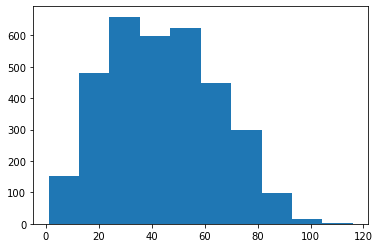

In [17]:
plt.hist(train['image_id'].value_counts(), bins=10)
plt.show()

Max number of bounding boxes is 116, whereas min (annotated) number is 1 

## Visualizing images

In [18]:
def show_images(images, num = 5):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_img, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in train[train['image_id'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], width=3)

        plt.figure(figsize = (15,15))
        plt.imshow(image)
        plt.show()

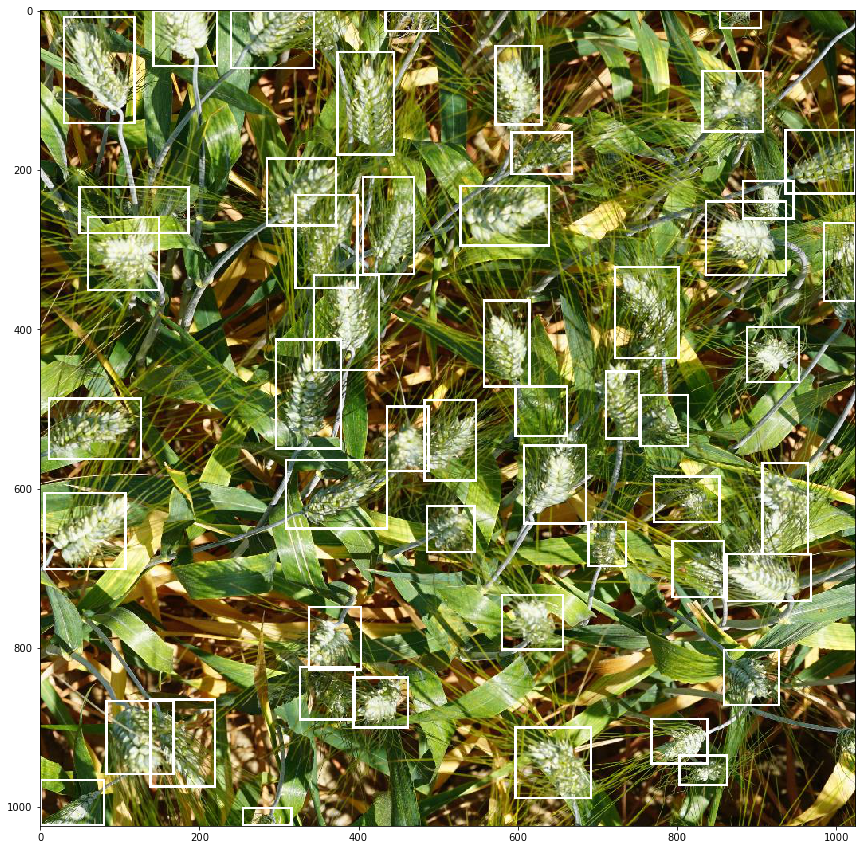

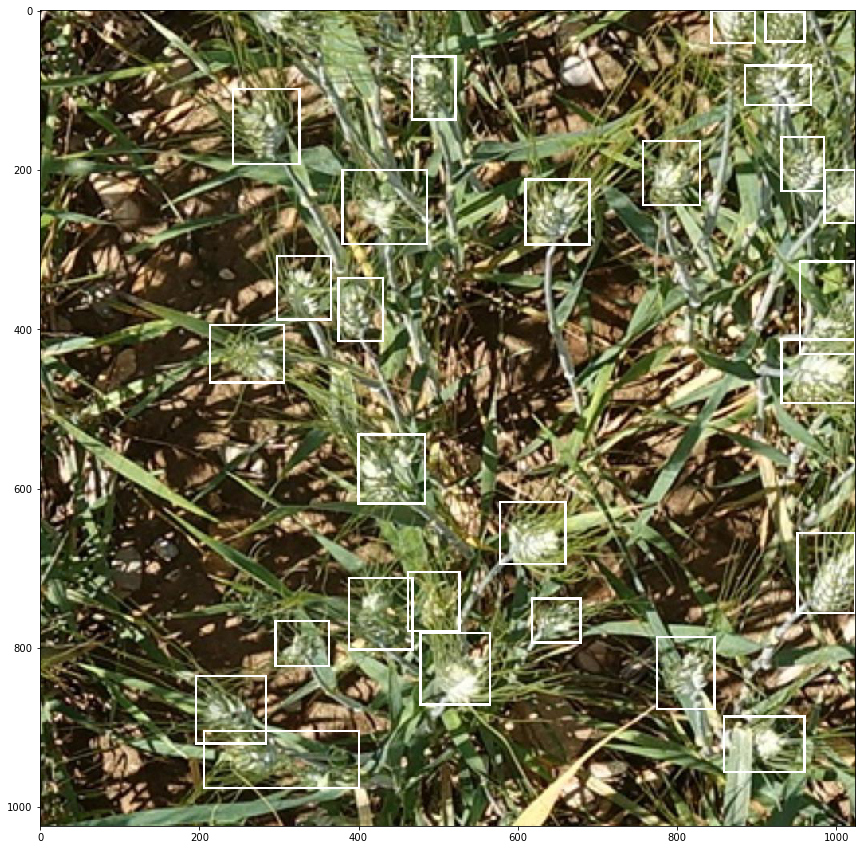

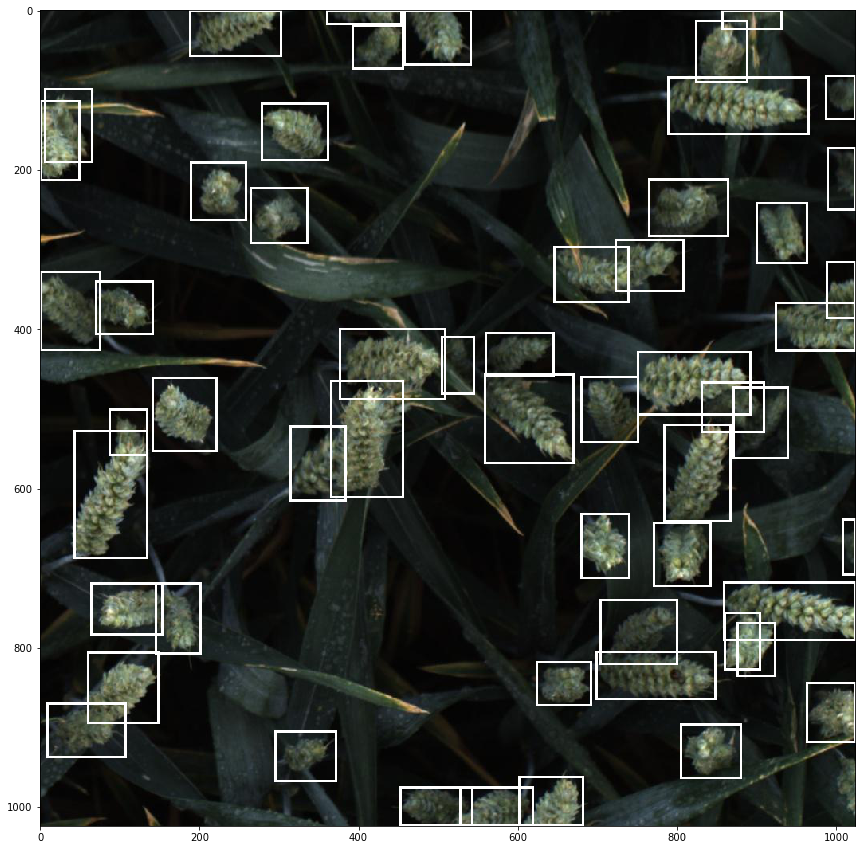

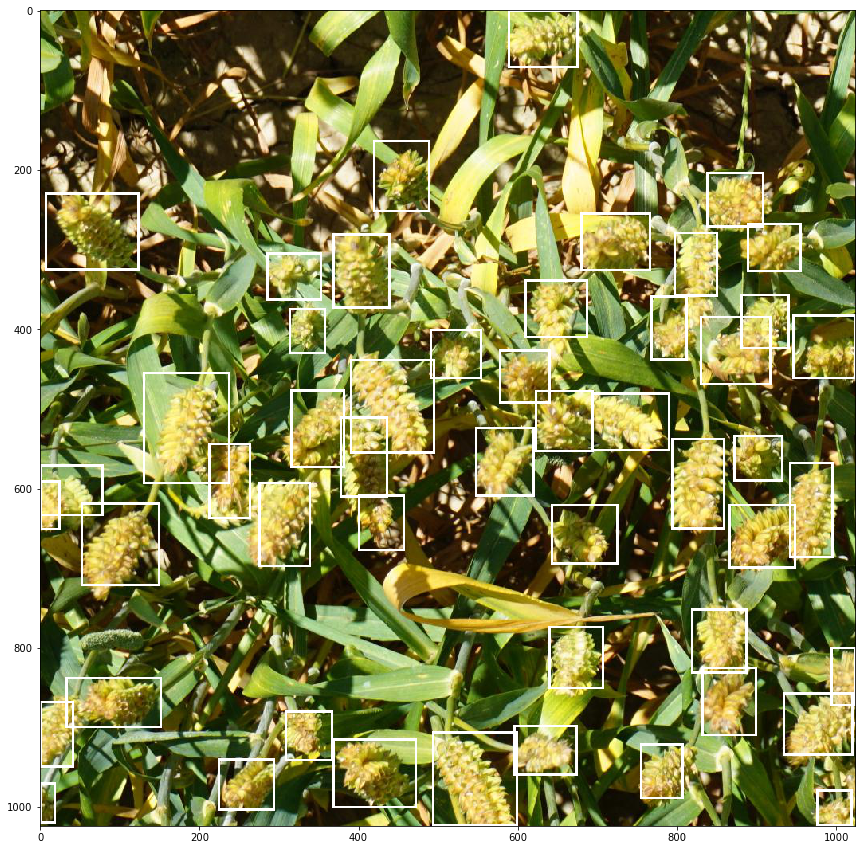

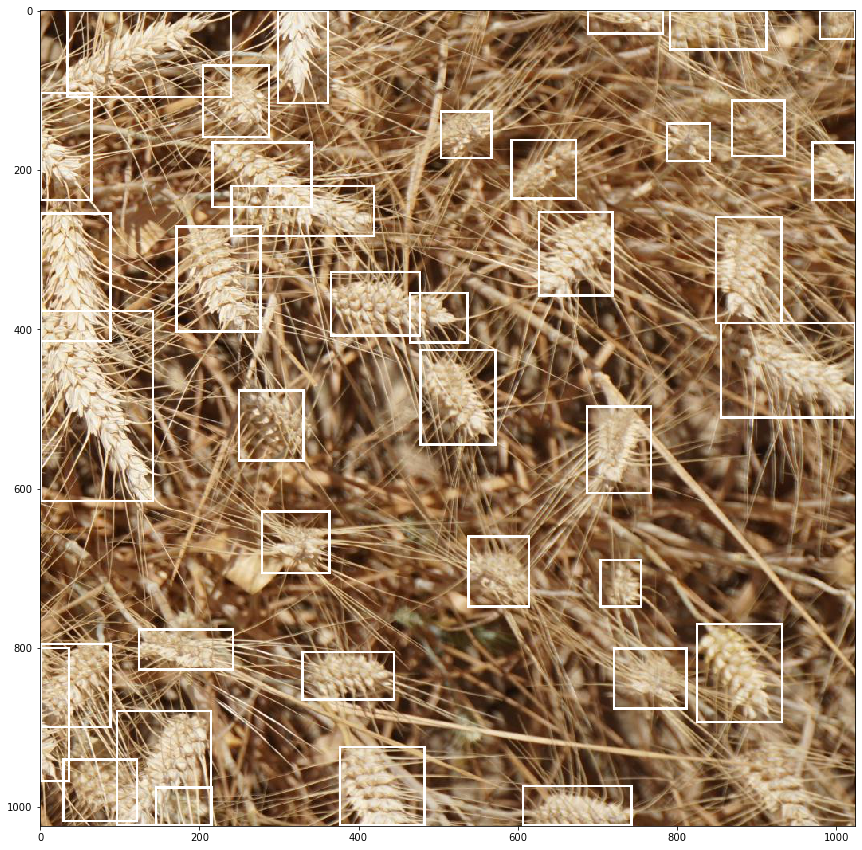

In [19]:
show_images(unique_images)

What can we tell from visualizations:

* there are plenty of overlappind bounding boxes
* all photos seem to be taken vertically 
* all plants are can be rotated differently, there is no single orientation. this means that different flip and roration augmentations should probably help
* colors of wheet heads are quite different and seem to depend a little bit on the source
* wheet heads themselves are seen from very different angles of view relevant to the observer

# Preprocessing Data for Input to RetinaNet

In [20]:
bboxs=[ bbox[1:-1].split(', ') for bbox in train['bbox']]
bboxs=[ f"{int(float(bbox[0]))},{int(float(bbox[1]))},{int(float(bbox[0]))+int(float(bbox[2]))},{int(float(bbox[1])) + int(float(bbox[3]))},wheat" for bbox in bboxs]
train['bbox_']=bboxs
train.head()

image_id  width  height                         bbox   source  bbox_area  \
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1     2016.0   
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1     7540.0   
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1    11840.0   
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1    11663.0   
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1    14508.0   

                   bbox_  
0  834,222,890,258,wheat  
1  226,548,356,606,wheat  
2  377,504,451,664,wheat  
3   834,95,943,202,wheat  
4   26,144,150,261,wheat

In [21]:
train_df=train[['image_id','bbox_']]
train_df.head()

image_id                  bbox_
0  b6ab77fd7  834,222,890,258,wheat
1  b6ab77fd7  226,548,356,606,wheat
2  b6ab77fd7  377,504,451,664,wheat
3  b6ab77fd7   834,95,943,202,wheat
4  b6ab77fd7   26,144,150,261,wheat

In [22]:
train_df=train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

image_id                  bbox_
0  96db737c8    845,25,914,58,wheat
1  682f78993  512,387,606,460,wheat
2  e8fb2db93  461,543,593,596,wheat
3  efe33a573  884,892,940,965,wheat
4  13a368f78  796,193,951,292,wheat

## Preparing Files to be given for training

### Annotation file contains all the path of all images and their corresponding bounding boxes
### Class file contains the number of classes but in our case it is just 1 (Wheat)

In [23]:
with open("annotations.csv","w") as file:
    for idx in range(len(train_df)):
        file.write(train_img+"/"+train_df.iloc[idx,0]+".jpg"+","+train_df.iloc[idx,1]+"\n")
        

In [24]:
with open("classes.csv","w") as file:
    file.write("wheat,0")

## Downloading the pretrained model

In [25]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


### Model Parameters

In [26]:
EPOCHS = 1
BATCH_SIZE=8
STEPS = 100 #len(train_df)//BATCH_SIZE #Keeping it small for faster commit
LR=1e-3

# Training Model

In [ ]:
!keras_retinanet/bin/train.py --random-transform --weights {PRETRAINED_MODEL} --lr {LR} --batch-size {BATCH_SIZE} --steps {STEPS} --epochs {EPOCHS} --no-resize csv annotations.csv classes.csv

Using TensorFlow backend.
2020-05-27 06:05:52.692722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-05-27 06:06:00.417346: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-27 06:06:00.717615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-27 06:06:00.718425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-05-27 06:06:00.718501: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[ -90.50967 ,  -45.254833,   90.50967 ,   45.254833],
       [-114.03504 ,  -57.01752 ,  114.03504 ,   57.01752 ],
       [-143.67514 ,  -71.83757 ,  143.67514 ,   71.83757 ],
       [ -64.      ,  -64.      ,   64.      ,   64.      ],
       [ -80.63495 ,  -80.63495 ,   80.63495 ,   80.63495 ],
       [-101.593666, -101.593666,  101.593666,  101.593666],
       [ -45.254833,  -90.50967 ,   45.254833,   90.50967 ],
       [ -57.01752 , -114.03504 ,   57.01752 ,  114.03504 ],
       [ -71.83757 , -143.67514 ,   71.83757 ,  143.67514 ]],
      dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-181.01933,  -90.50967,  181.01933,   90.50967],
       [-228.07008, -114.03504,  228.07008,  114.03504],
       [-287.35028, -143.67514,  287.35028,  143.67514],
       [-128.     , -128.     ,  128.     ,  128.     ],
       [-161.2699 , -161.2699 ,  161.2699 ,  161.269

res4f_branch2c (Conv2D)         (None, None, None, 1 262144      res4f_branch2b_relu[0][0]        
__________________________________________________________________________________________________
bn4f_branch2c (BatchNormalizati (None, None, None, 1 4096        res4f_branch2c[0][0]             
__________________________________________________________________________________________________
res4f (Add)                     (None, None, None, 1 0           bn4f_branch2c[0][0]              
                                                                 res4e_relu[0][0]                 
__________________________________________________________________________________________________
res4f_relu (Activation)         (None, None, None, 1 0           res4f[0][0]                      
__________________________________________________________________________________________________
res5a_branch2a (Conv2D)         (None, None, None, 5 524288      res4f_relu[0][0]                 
__________

Epoch 1/1
2020-05-27 06:06:36.671812: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-05-27 06:06:39.651395: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
  8/100 [=>............................] - ETA: 7:33 - loss: 2.5069 - regression_loss: 1.7665 - classification_loss: 0.7405

# Loading the trained model

In [ ]:
!ls snapshots

In [ ]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# Predictions

In [ ]:
li=os.listdir(test_img)
li[:5]

In [ ]:
def predict(image):
    image = preprocess_image(image.copy())
    #image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

    #boxes /= scale

    return boxes, scores, labels

In [ ]:
THRES_SCORE = 0.5

def draw_detections(image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{:.3f}".format(score)
        draw_caption(image, b, caption)

In [ ]:
def show_detected_objects(image_name):
    img_path = test_img+'/'+image_name
  
    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)
    print(boxes[0,0].shape)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_detections(draw, boxes, scores, labels)
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [ ]:
for img in li:
    show_detected_objects(img)

In [ ]:
preds=[]
imgid=[]
for img in tqdm(li,total=len(li)):
    img_path = test_img+'/'+img
    image = read_image_bgr(img_path)
    boxes, scores, labels = predict(image)
    boxes=boxes[0]
    scores=scores[0]
    for idx in range(boxes.shape[0]):
        if scores[idx]>THRES_SCORE:
            box,score=boxes[idx],scores[idx]
            imgid.append(img.split(".")[0])
            preds.append("{} {} {} {} {}".format(score, int(box[0]), int(box[1]), int(box[2]-box[0]), int(box[3]-box[1])))
    

In [ ]:
preds[0]

In [ ]:
sub={"image_id":imgid, "PredictionString":preds}
sub=pd.DataFrame(sub)
sub.head()

In [ ]:
sub_=sub.groupby(["image_id"])['PredictionString'].apply(lambda x: ' '.join(x)).reset_index()
sub_

In [ ]:
samsub=pd.read_csv("/kaggle/input/global-wheat-detection/sample_submission.csv")
samsub.head()

In [ ]:
for idx,imgid in enumerate(samsub['image_id']):
    samsub.iloc[idx,1]=sub_[sub_['image_id']==imgid].values[0,1]
    
samsub.head()

In [ ]:
samsub.to_csv('/kaggle/working/submission.csv',index=False)